# 1. Data Gnerator
- Raw data를 읽어와 세그먼트로 나누고 각 배치별로 패딩해주는 부분
- 여기서 만들어진 데이터는 모델의 입력으로 들어감

In [1]:
import os
import numpy as np
import librosa
from tensorflow.keras.utils import Sequence

In [2]:
class RawDataGenerator(Sequence):
    def __init__(self, Mix, wav_dir, files, batch_size=10, shuffle=True):
        self.Mix = Mix
        self.wav_dir = wav_dir
        self.files = files
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.Mix))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __audioread__(self, path, offset=0.0, duration=None, sample_rate=16000):
        signal = librosa.load(path, sr=sample_rate, mono=False, offset=offset, duration=duration)

        return signal[0]
    
    def __padding__(self, data):
        n_batch = len(data)
        max_len = max([d.shape[0] for d in data])
        pad = np.zeros((n_batch, max_len, data[0].shape[1]))
        
        for i in range(n_batch):
            pad[i, :data[i].shape[0]] = data[i]
        
        return pad
        
    def __data_generation__(self, Mix_list):
        sample_rate = 8000
        L = 40
        
        mix_wav_list = []
        label_wav_list = []
        for name in Mix_list:
            name = name.strip('\n')
            
            mix_wav_name = self.wav_dir + self.files + '/mix/' + name
            s1_wav_name = self.wav_dir + self.files + '/s1/' + name
            s2_wav_name = self.wav_dir + self.files + '/s2/' + name
            
            # ------- AUDIO READ -------
            mix_wav = (self.__audioread__(mix_wav_name, offset=0.0, duration=None, sample_rate=sample_rate))
            s1_wav = (self.__audioread__(s1_wav_name,  offset=0.0, duration=None, sample_rate=sample_rate))
            s2_wav = (self.__audioread__(s2_wav_name,  offset=0.0, duration=None, sample_rate=sample_rate))
            # --------------------------
            
            # ------- TIME AXIS CALCULATE -------
            K = int(np.ceil(len(mix_wav) / L))
            # -----------------------------------
            
            # ------- PADDING -------
            pad_len = K * L
            pad_mix = np.concatenate([mix_wav, np.zeros([pad_len - len(mix_wav)])])
            pad_s1 = np.concatenate([s1_wav, np.zeros([pad_len - len(s1_wav)])])
            pad_s2 = np.concatenate([s2_wav, np.zeros([pad_len - len(s2_wav)])])
            # -----------------------
            
            # ------- RESHAPE -------
            mix = np.reshape(pad_mix, [K, L])
            s1 = np.reshape(pad_s1, [K, L])
            s2 = np.reshape(pad_s2, [K, L])
            # -----------------------
            
            # ------- CONCAT S1 S2 -------
            s = np.concatenate([s1, s2], axis=-1) # [K x 2L]
            # ----------------------------
            
            mix_wav_list.append(mix)
            label_wav_list.append(s)
        
        return mix_wav_list, label_wav_list
            
    
    def __len__(self):
        return int(np.floor(len(self.Mix) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        Mix_list = [self.Mix[k] for k in indexes]
        
        if self.files is not 'tt':
            mix, labels = self.__data_generation__(Mix_list)
            
            # Get Lengths(K value of each batch)
            lengths = np.array([m.shape[0] for m in mix])
            tiled = np.tile(np.expand_dims(lengths, 1), [1, labels[0].shape[1]])
            tiled = np.expand_dims(tiled, 1)
            
            # Padding
            mix_pad = self.__padding__(mix) # [Batch, Time_step, Dimension]
            label_pad = self.__padding__(labels) # [Batch, Time_step, Dimension * 2]
            
            return mix_pad, np.concatenate([label_pad, tiled], axis=1)
        else:
            mix, labels = self.__data_generation__(Mix_list)
            
            # Get Lengths(K value of each batch)
            lengths = np.array([m.shape[0] for m in mix])
            tiled = np.tile(np.expand_dims(lengths, 1), [1, labels[0].shape[1]])
            tiled = np.expand_dims(tiled, 1)
            
            # Padding
            mix_pad = self.__padding__(mix) # [Batch, Time_step, Dimension]
            
            return mix_pad, tiled

## Data를 어떻게 읽는지에 대한 부분

In [3]:
WAV_DIR = './mycode/wsj0_2mix/use_this/'
LIST_DIR = './mycode/wsj0_2mix/use_this/lists/'

In [4]:
# Directory List file create

wav_dir = WAV_DIR
output_lst = LIST_DIR

for folder in ['tr', 'cv', 'tt']:
    wav_files = os.listdir(wav_dir + folder + '/mix')
    output_lst_files = output_lst + folder + '_wav.lst'
    with open(output_lst_files, 'w') as f:
        for file in wav_files:
            f.write(file + "\n")

print("Generate wav file to .lst done!")

Generate wav file to .lst done!


In [5]:
batch_size = 2

train_dataset = 0
valid_dataset = 0
test_dataset = 0

name_list = []
for files in ['tr', 'cv', 'tt']:
    # --- Lead lst file ---
    output_lst_files = LIST_DIR + files + '_wav.lst'
    fid = open(output_lst_files, 'r')
    lines = fid.readlines()
    fid.close()
    # ---------------------
    
    if files == 'tr':
        train_dataset = RawDataGenerator(lines, WAV_DIR, files, batch_size)
    elif files == 'cv':
        valid_dataset = RawDataGenerator(lines, WAV_DIR, files, batch_size)
    else:
        test_dataset = RawDataGenerator(lines, WAV_DIR, files, batch_size)

## 2. Building model

In [6]:
import threading, sys, os
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Reshape, LSTM, Concatenate, Multiply, Bidirectional, Dropout, Conv1D
from tensorflow.keras import optimizers
from tensorflow import keras

import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [7]:
def mkdir_p(path):
    """ Creates a path recursively without throwing an error if it already exists
    :param path: path to create
    :return: None
    """
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:
mkdir_p('./CKPT/') # model check point 폴더 만드는 코드
filepath = "./CKPT/CKP_ep_{epoch:d}__loss_{val_loss:.5f}_.h5"

In [9]:
initial_learning_rate = 0.001

# learning rate를 점점 줄이는 부분
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

# validation loss에 대해서 좋은 것만 저장됨
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

# early stop 하는 부분인데, validation loss에 대해서 제일 좋은 모델이 저장됨
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True
)

In [10]:
# # Custom PIT loss

# def pit_with_outputsize(output_size):
#     def pit_loss(y_true, y_pred):
#         ori_length = tf.shape(y_true)[1]
        
#         # Label & Length divide
#         labels = tf.slice(y_true, [0, 0, 0], [-1, ori_length-1, -1]) # [batch_size, length_size, 129]
#         lengths = tf.slice(y_true, [0, ori_length-1, 0], [-1, -1, 1]) # [batch_size, 1, 1]
        
#         # Label value slice
#         labels1 = tf.slice(labels, [0, 0, 0], [-1, -1, output_size])
#         labels2 = tf.slice(labels, [0, 0, output_size], [-1, -1, -1])

#         # Predict value slice
#         pred1 = tf.slice(y_pred, [0, 0, 0], [-1, -1, output_size])
#         pred2 = tf.slice(y_pred, [0, 0, output_size], [-1, -1, -1])

#         # Permute calculate
#         cost1 = tf.reduce_mean(tf.reduce_sum(tf.pow(pred1 - labels1, 2), 1) + tf.reduce_sum(tf.pow(pred2 - labels2, 2), 1), 1)
#         cost2 = tf.reduce_mean(tf.reduce_sum(tf.pow(pred2 - labels1, 2), 1) + tf.reduce_sum(tf.pow(pred1 - labels2, 2), 1), 1)

#         idx = tf.cast(cost1 > cost2, tf.float32) 
#         pit_loss = tf.reduce_sum(idx * cost2 + (1 - idx) * cost1)
        
#         return pit_loss
    
#     return pit_loss

def pit_with_outputsize(output_size):
    def pit_loss(y_true, y_pred):
        ori_length = tf.shape(y_true)[1]

        # Label & Length divide
        labels = tf.slice(y_true, [0, 0, 0], [-1, ori_length-1, -1]) # [batch_size, length_size, 129]
        lengths = tf.slice(y_true, [0, ori_length-1, 0], [-1, -1, 1]) # [batch_size, 1, 1]

        mask = tf.cast(tf.sequence_mask(tf.squeeze(lengths), tf.shape(y_pred)[1]), tf.float32)
        mask = tf.expand_dims(mask, axis=-1)
        mask = tf.tile(mask, [1, 1, output_size])
        print(tf.shape(mask))

        # Label value slice
        labels1 = tf.slice(labels, [0, 0, 0], [-1, -1, output_size])
        labels2 = tf.slice(labels, [0, 0, output_size], [-1, -1, -1])

        # Predict value slice
        pred1 = tf.slice(y_pred, [0, 0, 0], [-1, -1, output_size])
        pred2 = tf.slice(y_pred, [0, 0, output_size], [-1, -1, -1])

        # Masking
        mask_pred1 = pred1 * mask
        mask_pred2 = pred2 * mask

        # Permute calculate (batch, seqlen, 258) mask = (batch, seq_len)
        cost1 = tf.reduce_sum(tf.pow(mask_pred1 - labels1, 2), 1) + tf.reduce_sum(tf.pow(mask_pred2 - labels2, 2), 1)
        cost1 = tf.reduce_sum(cost1, 1) / tf.squeeze(lengths)
        cost2 = tf.reduce_sum(tf.pow(mask_pred2 - labels1, 2), 1) + tf.reduce_sum(tf.pow(mask_pred1 - labels2, 2), 1)
        cost2 = tf.reduce_sum(cost2, 1) / tf.squeeze(lengths)

        idx = tf.cast(cost1 > cost2, tf.float32) 
        pit_loss = tf.reduce_sum(idx * cost2 + (1 - idx) * cost1)

        return pit_loss
        
    return pit_loss

In [11]:
# our model

def uPIT(input_size, output_size, batch):
    inputs = Input(shape=(None, input_size))
    
    outputs = Conv1D(filters=129, kernel_size=2, activation = 'sigmoid', padding='same')(inputs)
    
    outputs = Bidirectional(LSTM(129, activation = 'tanh', return_sequences=True),
                           input_shape=(None, 129,))(outputs)
    drop = Dropout(rate=0.8)(outputs)
    outputs = Bidirectional(LSTM(129, activation = 'tanh', return_sequences=True))(drop)
    drop = Dropout(rate=0.8)(outputs)
    outputs = Bidirectional(LSTM(129, activation = 'tanh', return_sequences=True))(drop)
    drop = Dropout(rate=0.8)(outputs)
    
    pred1 = Dense(output_size, activation = 'relu')(drop)
    pred2 = Dense(output_size, activation = 'relu')(drop)
    
    cleaned1 = Multiply()([pred1, inputs])
    cleaned2 = Multiply()([pred2, inputs])
    
    model = Concatenate()([cleaned1, cleaned2])
    
    model = keras.Model(inputs, model)
    
    model.summary()
    adam = tf.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss=pit_with_outputsize(output_size), optimizer=adam)
#     model.compile(loss=keras.losses.mean_squared_error, optimizer=adam)

    return model

## 3. Training model

In [12]:
# Training part

epoch = 5
L = 40
OUTPUT_SIZE = 40
BATCH_SIZE = 2

strategy = tf.distribute.MirroredStrategy()
print('장치의 수: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    # 사용 안할 때는 load_model 주석 처리 하자
#     model = load_model('./CKPT/CKP_ep_29__loss_102.63367_.h5', custom_objects={'pit_loss': pit_with_outputsize(OUTPUT_SIZE)})
    
    model = uPIT(L, OUTPUT_SIZE, BATCH_SIZE)
    tf.executing_eagerly()

history = model.fit(
    train_dataset,
    epochs=epoch,
    validation_data=valid_dataset,
    shuffle=True,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
장치의 수: 1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 40)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 129)    10449       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 258)    267288      conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 258)    0           bidirectional[0][

KeyboardInterrupt: 

## 4. Training and validation loss plot

In [13]:
# Show training and validation loss graph

def graph_util(history):
    fig = plt.figure()
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(history.history['loss'], c='b')
    plt.plot(history.history['val_loss'], c='r')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper left')
    
    plt.show()

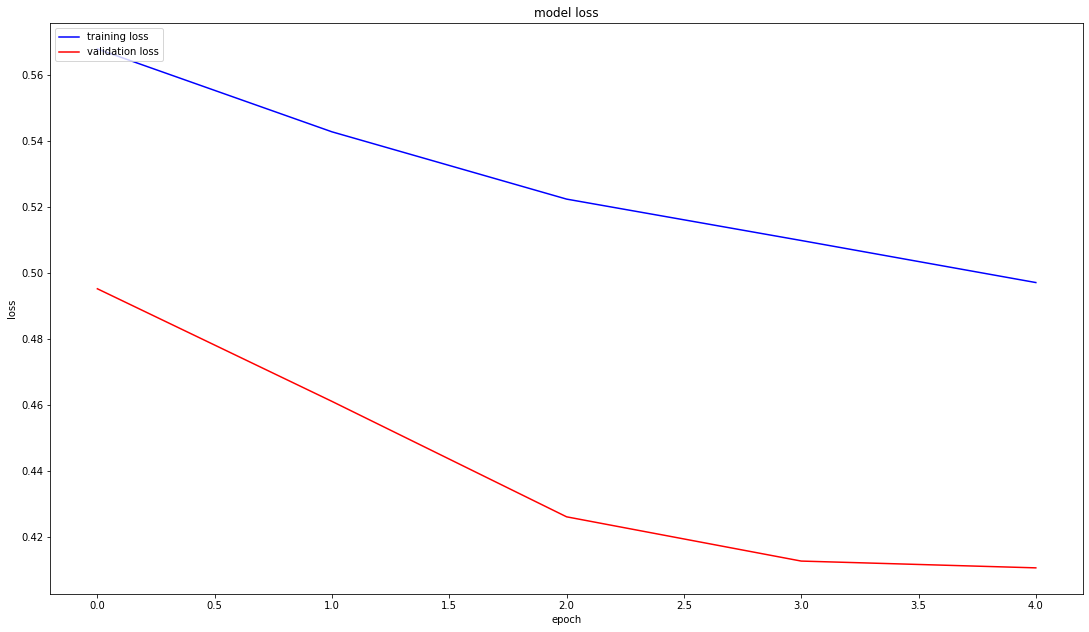

In [14]:
graph_util(history)